Data on taxi trips in New York City, data from : https://www.kaggle.com/c/nyc-taxi-trip-duration

Notebook inspired from : https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

Predict taxi trip durations 

In [21]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

In [22]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

Quickview of data

In [23]:
print(test.shape)
print(train.shape)
train.head()

(625134, 9)
(1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [24]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Histogram of trip duration of taxi trips

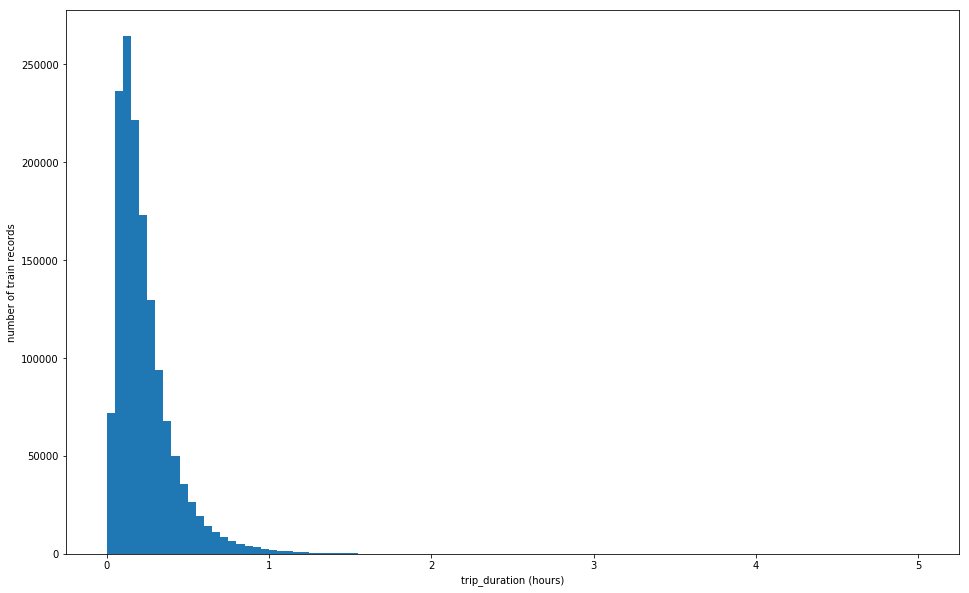

In [25]:
plt.hist(train['trip_duration'].values/3600, bins=100, range=[0,5])
plt.xlabel('trip_duration (hours)')
plt.ylabel('number of train records')
plt.show()

In [26]:
train.trip_duration.max() // 3600

979

Plot pickup locations

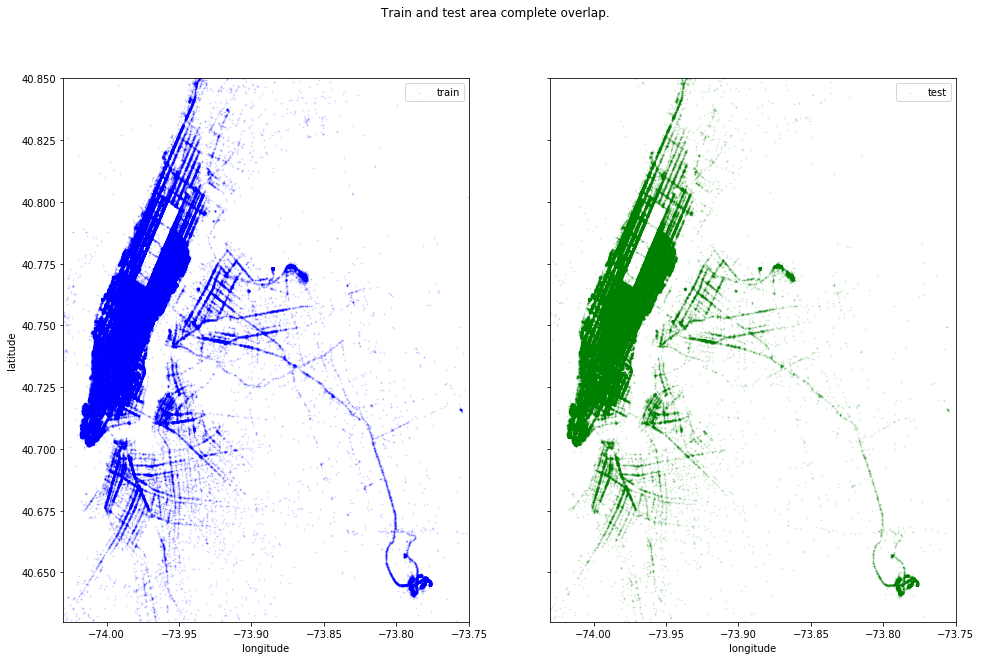

In [27]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values, train['pickup_latitude'].values,
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values, test['pickup_latitude'].values,
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Functions for calculating distance

In [28]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

Create distance features

In [30]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)


test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

Create time features

In [46]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

Plot speed of taxis vs time of day

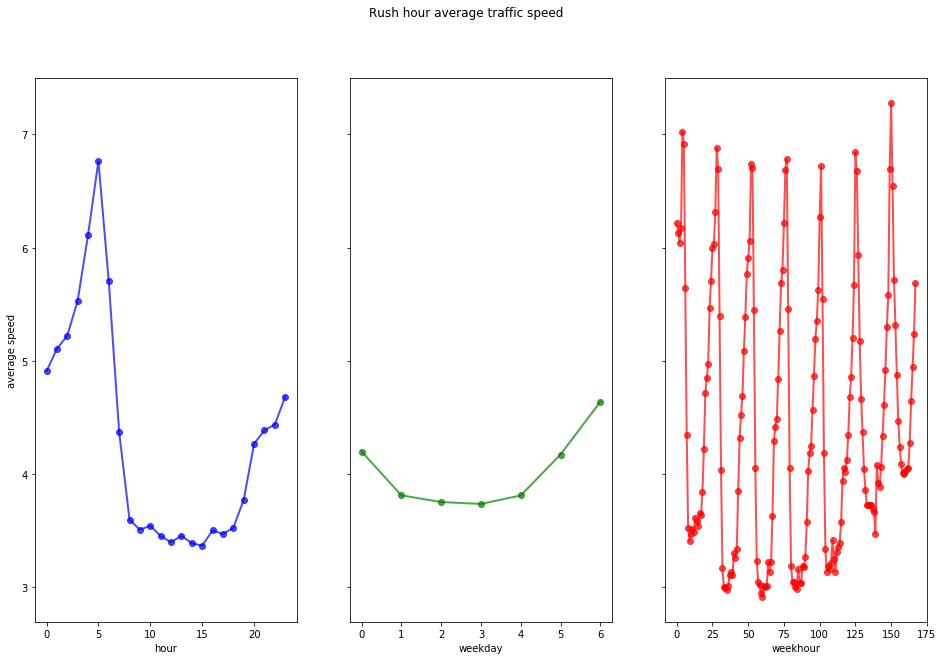

In [47]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

In [ ]:
Set features for training

In [48]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)


['avg_speed_h' 'avg_speed_m' 'dropoff_datetime' 'trip_duration']
We have 18 features.


In [49]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)

In [44]:
print(feature_names)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour']


Begin training and classification using xgboost

In [50]:

print(Xtr)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

[[  1.00000000e+00   4.00000000e+00  -7.39682770e+01 ...,   5.40000000e+01
    5.57964200e+06   1.33000000e+02]
 [  1.00000000e+00   1.00000000e+00  -7.39719391e+01 ...,   5.70000000e+01
    1.36906410e+07   3.40000000e+01]
 [  1.00000000e+00   1.00000000e+00  -7.39749985e+01 ...,   4.30000000e+01
    4.11738800e+06   6.30000000e+01]
 ..., 
 [  2.00000000e+00   3.00000000e+00  -7.39883423e+01 ...,   2.70000000e+01
    1.54602900e+06   2.10000000e+01]
 [  1.00000000e+00   1.00000000e+00  -7.39820251e+01 ...,   3.20000000e+01
    8.14874500e+06   7.00000000e+00]
 [  2.00000000e+00   1.00000000e+00  -7.40004501e+01 ...,   1.30000000e+01
    1.21796130e+07   1.19000000e+02]]


In [51]:
# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.22809	valid-rmse:4.22908
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.448406	valid-rmse:0.457631
[20]	train-rmse:0.400469	valid-rmse:0.414218
[30]	train-rmse:0.384507	valid-rmse:0.402143
[40]	train-rmse:0.379612	valid-rmse:0.39977
[50]	train-rmse:0.374524	valid-rmse:0.397381
[59]	train-rmse:0.370875	valid-rmse:0.396011


Create predictions

Test shape OK.
Valid prediction mean: 6.467
Test prediction mean: 6.466


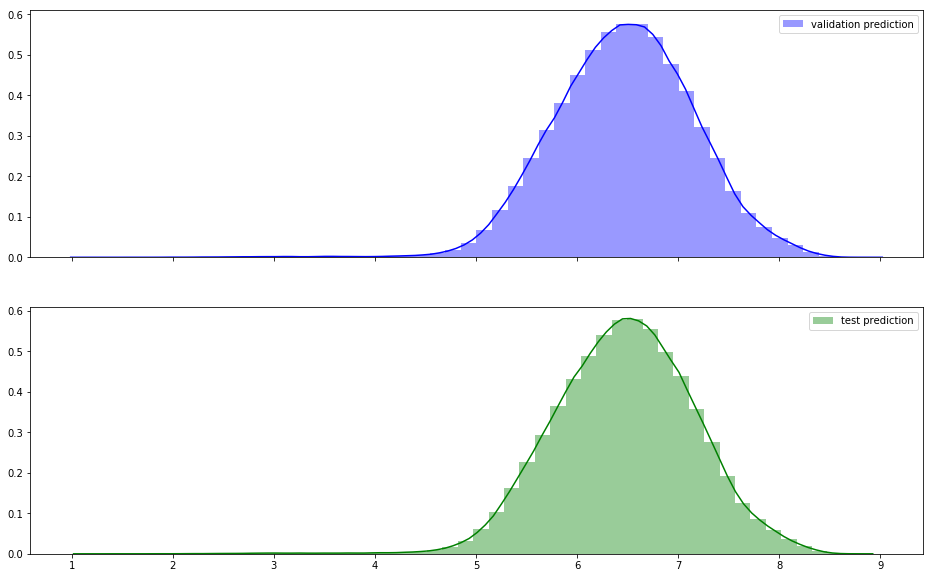

In [53]:
ytest = model.predict(dtest)
ypred = model.predict(dvalid)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('beluga_xgb_submission.csv.gz', index=False, compression='gzip')

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()